# 0. Imports

In [1]:
import os
import json
import collections
import numpy as np
import pickle
import datetime

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [2]:
# Chemin du fichier d'annotations
annotation_folder = "/captionning_data/annotations/"
annotation_file = os.path.abspath('.') + annotation_folder + "captions_train2014.json"

# Chemin du dossier contenant les images à annoter
image_folder = '/captionning_data/train2014/'
PATH = os.path.abspath('.') + image_folder

temp_folder = os.path.join(os.path.abspath('.'), "Tests")

# 1. Chargement des données

In [3]:
def load_annotations():
    # Lecture du fichier d'annotation
    with open(annotation_file, 'r') as f:
        annotations = json.load(f)
        
    # Grouper toutes les annotations ayant le meme identifiant.
    image_path_annotation = collections.defaultdict(list)
    for val in annotations['annotations']:
        # marquer le debut et la fin de chaque annotation
        caption = val['caption']

        # L'identifiant d'une image fait partie de son chemin d'accès
        image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])

        # Rajout du caption associé à image_path
        image_path_annotation[image_path].append(caption)
        
    return image_path_annotation

In [4]:
data_annotations = load_annotations()
print("Nb annotations :", len(data_annotations))

Nb annotations : 82783


data_annotations = dict(list(data_annotations.items())[:10000])
print("Nb annotations :", len(data_annotations))

In [6]:
def load_dataset_from_annotations(data_annotations):
    # Liste de toutes les annotations
    train_captions = []
    # Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
    img_name_vector = []

    for image_path in data_annotations:
        caption_list = data_annotations[image_path]

        # Rajout de caption_list dans train_captions
        train_captions.extend(caption_list)

        # Rajout de image_path dupliquée len(caption_list) fois
        img_name_vector.extend([image_path] * len(caption_list))
        
    return np.column_stack((img_name_vector, train_captions))

In [7]:
dataset = load_dataset_from_annotations(data_annotations)
print("Taille du dataset :", dataset.shape)
print(dataset)

Taille du dataset : (50020, 2)
[['C:\\Users\\2113264\\Documents\\Projet/captionning_data/train2014/COCO_train2014_000000318556.jpg'
  'A very clean and well decorated empty bathroom']
 ['C:\\Users\\2113264\\Documents\\Projet/captionning_data/train2014/COCO_train2014_000000318556.jpg'
  'A blue and white bathroom with butterfly themed wall tiles.']
 ['C:\\Users\\2113264\\Documents\\Projet/captionning_data/train2014/COCO_train2014_000000318556.jpg'
  'A bathroom with a border of butterflies and blue paint on the walls above it.']
 ...
 ['C:\\Users\\2113264\\Documents\\Projet/captionning_data/train2014/COCO_train2014_000000570295.jpg'
  'The bathroom has a white tub and toilet.']
 ['C:\\Users\\2113264\\Documents\\Projet/captionning_data/train2014/COCO_train2014_000000570295.jpg'
  'An all white bathroom is shown wish a large tub.']
 ['C:\\Users\\2113264\\Documents\\Projet/captionning_data/train2014/COCO_train2014_000000570295.jpg'
  'A white toilet and a bath in a room.']]


## 2. Preprocessing 

In [8]:
def feature_preprocessing(dataset):
    # Load the inception v3 model
    input1 = InceptionV3(weights='imagenet')

    # Create a new model, by removing the last layer (output layer) from the inception v3
    model = Model(input1.input, input1.layers[-2].output)

    model.summary()
    
    features = {}
    
    for img_path in tqdm(np.unique(dataset[:,0])):
        # Convert all the images to size 299x299 as expected by the inception v3 model
        image = keras.preprocessing.image.load_img(img_path, target_size=(299, 299))
        # Convert PIL image to numpy array of 3-dimensions
        image = keras.preprocessing.image.img_to_array(image)
        # Add one more dimension
        image = np.expand_dims(image, axis=0)
        # pre-process the images using preprocess_input() from inception module
        image = keras.applications.inception_v3.preprocess_input(image)
        
        fea_vec = model.predict(image, verbose=False) # Get the encoding vector for the image
        fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
        
        features[img_path] = fea_vec
        
    return features

In [ ]:
# store features in pickle
os.makedirs(temp_folder, exist_ok=True)
with open(os.path.join(temp_folder, "features.pkl"), "wb") as encoded_pickle:
    pickle.dump(feature_preprocessing(dataset), encoded_pickle)

In [9]:
# load features from pickle
with open(os.path.join(temp_folder, "features.pkl"), 'rb') as f:
    features = pickle.load(f)

In [10]:
def clean(dataset):
    cleaned = []
    
    for key_input, caption_input in dataset:
        # preprocessing steps
        # convert to lowercase
        caption = caption_input.lower()
        caption = caption.replace('.', '')
        # delete digits, special chars, etc., 
        caption = caption.replace('[^A-Za-z]', '')
        # delete additional spaces
        caption = caption.replace('\s+', ' ')
        # add start and end tags to the caption
        caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
        
        cleaned.append((key_input, caption))
        
    return np.array(cleaned)

In [11]:
cleaned_dataset = clean(dataset)

In [12]:
print("Dataset valeur 1 :", dataset[0][1])
print("Cleaned valeur 1 :", cleaned_dataset[0][1])
print("Dataset valeur 2 :", dataset[1][1])
print("Cleaned valeur 2 :", cleaned_dataset[1][1])

Dataset valeur 1 : A very clean and well decorated empty bathroom
Cleaned valeur 1 : startseq very clean and well decorated empty bathroom endseq
Dataset valeur 2 : A blue and white bathroom with butterfly themed wall tiles.
Cleaned valeur 2 : startseq blue and white bathroom with butterfly themed wall tiles endseq


## 3. Processing des Textes

In [13]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(cleaned_dataset[:,1])
vocab_size = len(tokenizer.word_index) + 1
print("Nombre de mot unique :", vocab_size)

Nombre de mot unique : 9017


In [14]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in cleaned_dataset[:,1])
print("Taille maximum des descriptions :", max_length)

Taille maximum des descriptions : 45


## 4. Train Test Split

In [15]:
split = int(len(cleaned_dataset) * 0.90)
split_train = int(split * 0.80)
train = cleaned_dataset[:split_train]
val = cleaned_dataset[split_train:split]
test = cleaned_dataset[split:]

In [16]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key, caption in data:
            n += 1
            # encode the sequence
            seq = tokenizer.texts_to_sequences([caption])[0]
            # split the sequence into X, y pairs
            for i in range(1, len(seq)):
                # split into input and output pairs
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                # store the sequences
                X1.append(features[key])
                X2.append(in_seq)
                y.append(out_seq)

            if n == batch_size:
                yield ((tf.convert_to_tensor(np.array(X1)), tf.convert_to_tensor(np.array(X2))), tf.convert_to_tensor(np.array(y)))
                X1, X2, y = list(), list(), list()
                n = 0
        # handle the last batch which might be smaller than batch_size
        if 0 < n < batch_size:
            yield ((tf.convert_to_tensor(np.array(X1)), tf.convert_to_tensor(np.array(X2))), tf.convert_to_tensor(np.array(y)))
            X1, X2, y = list(), list(), list()
            n = 0

## 5. Model

In [17]:
model = None
with tf.device('/GPU:0'):
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    model.layers[2].set_weights([np.zeros((vocab_size, 256))])
    model.layers[2].trainable = False

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 45, 256)      2308352     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_1[0][0]']                
                                                                                              

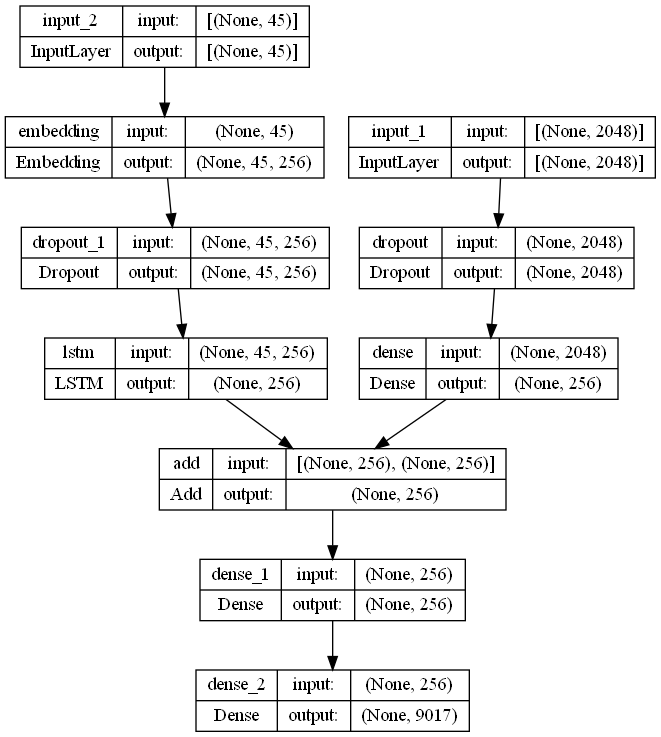

In [18]:
# plot the model
plot_model(model, show_shapes=True)

## 6. Train Model

In [19]:
# train the model
epochs = 20
batch_size = 32

train_steps = len(train) // batch_size
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train, features, tokenizer, max_length, vocab_size, batch_size),
    output_signature=(
        (tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),  # X1 shape
         tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),  # X2 shape
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # y shape
    )
)

val_steps = len(val) // batch_size
val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val, features, tokenizer, max_length, vocab_size, batch_size),
    output_signature=(
        (tf.TensorSpec(shape=(None, 2048), dtype=tf.float32),  # X1 shape
         tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),  # X2 shape
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)  # y shape
    )
)

In [ ]:
date = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(temp_folder, "logs/fit/captioning/" + date)
os.makedirs(log_dir, exist_ok=True)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

model_checkpoint_directory = os.path.join(temp_folder, f"weights/captioning/{date}/")
os.makedirs(model_checkpoint_directory, exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{model_checkpoint_directory}{{epoch:02d}}-{{val_loss:.4f}}.h5",
    save_weights_only=True,
    monitor='val_loss',
    save_freq='epoch',
    save_best_only=False)

with tf.device('/GPU:0'):
    model.fit(train_dataset, validation_data=val_dataset, epochs=epochs, steps_per_epoch=train_steps, validation_steps=val_steps, callbacks=[tensorboard_callback, model_checkpoint_callback])

Epoch 1/20
1125/1125 [==============================] - 231s 203ms/step - loss: 5.0872 - val_loss: 5.1243
Epoch 2/20
1125/1125 [==============================] - 233s 207ms/step - loss: 4.6792 - val_loss: 5.0516
Epoch 3/20
1125/1125 [==============================] - 227s 202ms/step - loss: 4.5368 - val_loss: 5.0732
Epoch 4/20
1125/1125 [==============================] - 228s 202ms/step - loss: 4.4371 - val_loss: 5.1382
Epoch 5/20
 437/1125 [==========>...................] - ETA: 2:08 - loss: 4.3837